#### Challenge - Boston Marathon

There is a lot of information on runners and their performance for the Boston Marathon. Pick a year (post-2012 has more info) and do some clustering.

Specifically, use the tools at hand to determine which clustering solution, including number of clusters and algorithm used, is best for the marathon data. Once you have a solution you like, write a data story, including visualizations, where you teach the reader something about the Boston Marathon based on your clusters. Write up your report, including your process from start to finish, in a Jupyter notebook and submit it below.

I will be using the [2014 data](https://github.com/llimllib/bostonmarathon/tree/master/results/2014) and perform the following:

- Apply dimensionality reduction techniques to visualize the observations.
- Apply clustering techniques to group together similar observations.

Also try alternative methods and select a best performing one. And finally discuss how dimensionality reduction and clustering algorithms enable us to gain insights regarding the data.

In [1]:
#Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AffinityPropagation
from sklearn import metrics

import warnings
warnings.filterwarnings(action="ignore")


In [2]:
#Load the data set
results = pd.read_csv('results.csv')
results.head()

,10k,name,division,25k,gender,age,official,bib,genderdiv,ctz,...,overall,pace,state,30k,5k,half,20k,country,city,40k
0,17.37,"Yamamoto, Hiroyuki",8,47.67,M,47,85.25,W1,8,NaN,...,8,3.27,NaN,59.18,8.02,39.72,37.65,JPN,Fukuoka,80.43
1,32.58,"Jeptoo, Rita",1,82.43,F,33,138.95,F1,1,NaN,...,21,5.30,NaN,99.33,16.22,69.47,65.83,KEN,Eldoret,132.10
2,16.62,"Van Dyk, Ernst F.",1,45.80,M,41,80.60,W2,1,NaN,...,1,3.08,NaN,56.45,7.75,38.03,36.10,RSA,Paarl,76.10
3,32.57,"Dibaba, Mare",3,82.43,F,24,140.58,F2,3,NaN,...,27,5.37,NaN,99.33,16.20,69.47,65.83,ETH,Shoa,132.95
4,17.12,"Hokinoue, Kota",2,46.37,M,40,81.23,W3,2,NaN,...,2,3.10,NaN,57.03,8.02,38.60,36.58,JPN,Nogata Fukuoka,76.72


In [3]:
results.shape

(31984, 21)

In [4]:
results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31984 entries, 0 to 31983
Data columns (total 21 columns):
10k          31984 non-null object
name         31984 non-null object
division     31984 non-null int64
25k          31984 non-null object
gender       31984 non-null object
age          31984 non-null int64
official     31984 non-null float64
bib          31984 non-null object
genderdiv    31984 non-null int64
ctz          1244 non-null object
35k          31984 non-null object
overall      31984 non-null int64
pace         31984 non-null float64
state        29408 non-null object
30k          31984 non-null object
5k           31984 non-null object
half         31984 non-null object
20k          31984 non-null object
country      31984 non-null object
city         31983 non-null object
40k          31984 non-null object
dtypes: float64(2), int64(4), object(15)
memory usage: 5.1+ MB


In [5]:
#count missing values
missing_vals = (results.isnull().sum()/len(results)).sort_values(ascending=False)

# keep column names that do have them
missing_vals = missing_vals[missing_vals > 0]

# data types
missValDTypes = results[missing_vals.index.to_list()].dtypes

print("**Missing value percentages:** Total values: {}".format(len(results)))
print(missing_vals, '\n')

**Missing value percentages:** Total values: 31984
ctz      0.961106
state    0.080540
city     0.000031
dtype: float64 



In [6]:
#Separate categorical and numberical columns
cat_col = results.dtypes[results.dtypes == 'object']
num_col = results.dtypes[results.dtypes != 'object']

In [7]:
for col in list(cat_col.index):
    print(f"--------------------{col.title()}-------------------------")
    total= results[col].value_counts()
    percent = results[col].value_counts() / results.shape[0]
    cat_df = pd.concat([total,percent],keys = ['total','percent'],axis = 1)
    print(cat_df)
    print('\n')

--------------------10K-------------------------
       total   percent
-         50  0.001563
48.97     47  0.001469
48.38     47  0.001469
48.75     42  0.001313
48.02     42  0.001313
48.87     41  0.001282
47.62     41  0.001282
49.42     41  0.001282
48.95     40  0.001251
47.88     40  0.001251
48.30     40  0.001251
49.47     39  0.001219
48.28     38  0.001188
47.20     38  0.001188
49.30     37  0.001157
48.65     37  0.001157
49.88     37  0.001157
47.13     37  0.001157
48.03     37  0.001157
48.17     37  0.001157
49.32     36  0.001126
47.80     36  0.001126
48.25     36  0.001126
47.95     36  0.001126
50.05     36  0.001126
48.08     36  0.001126
49.73     36  0.001126
49.03     36  0.001126
42.35     36  0.001126
49.02     36  0.001126
...      ...       ...
78.25      1  0.000031
79.92      1  0.000031
81.58      1  0.000031
32.97      1  0.000031
74.67      1  0.000031
74.30      1  0.000031
67.73      1  0.000031
30.83      1  0.000031
82.38      1  0.000031
76.25   

[8090 rows x 2 columns]


--------------------5K-------------------------
       total   percent
23.93     81  0.002533
23.88     79  0.002470
23.48     78  0.002439
24.47     75  0.002345
24.08     75  0.002345
24.10     73  0.002282
24.07     72  0.002251
23.17     72  0.002251
23.68     72  0.002251
24.45     71  0.002220
23.95     70  0.002189
24.02     70  0.002189
24.35     70  0.002189
24.30     69  0.002157
24.15     69  0.002157
24.05     68  0.002126
23.83     68  0.002126
24.72     68  0.002126
24.37     67  0.002095
24.73     67  0.002095
23.63     66  0.002064
24.32     66  0.002064
24.80     66  0.002064
24.23     66  0.002064
23.52     65  0.002032
23.57     64  0.002001
23.47     64  0.002001
24.13     64  0.002001
24.33     64  0.002001
24.58     64  0.002001
...      ...       ...
55.00      1  0.000031
39.23      1  0.000031
39.13      1  0.000031
9.77       1  0.000031
38.83      1  0.000031
41.42      1  0.000031
40.93      1  0.000031
46.47      1  0.000031
37.18 

In [8]:
#Drop ctz as it has 96% missing values, name and bib as they are unique to each runner.
results = results.drop(['name', 'bib','ctz'], axis=1)

#Binarize Gender as 0 for female and 1 for male
results.gender = results.gender.map(lambda x: 0 if x is 'F' else 1)

In [9]:
results.head()

,10k,division,25k,gender,age,official,genderdiv,35k,overall,pace,state,30k,5k,half,20k,country,city,40k
0,17.37,8,47.67,1,47,85.25,8,71.40,8,3.27,NaN,59.18,8.02,39.72,37.65,JPN,Fukuoka,80.43
1,32.58,1,82.43,0,33,138.95,1,116.37,21,5.30,NaN,99.33,16.22,69.47,65.83,KEN,Eldoret,132.10
2,16.62,1,45.80,1,41,80.60,1,67.42,1,3.08,NaN,56.45,7.75,38.03,36.10,RSA,Paarl,76.10
3,32.57,3,82.43,0,24,140.58,3,116.37,27,5.37,NaN,99.33,16.20,69.47,65.83,ETH,Shoa,132.95
4,17.12,2,46.37,1,40,81.23,2,67.83,2,3.10,NaN,57.03,8.02,38.60,36.58,JPN,Nogata Fukuoka,76.72


In [10]:
results.nunique()

10k           2766
division      6979
25k           6570
gender           2
age             64
official     11030
genderdiv    17575
35k           9516
overall      31931
pace           727
state           68
30k           8090
5k            1491
half          5651
20k           5375
country         78
city          5934
40k          10546
dtype: int64

In [11]:
# Let us convert the race run time records from object to numeric type.
race_types = ['5k', '10k', 'half', '20k', '25k', '30k', '35k', '40k']

for i in race_types:
    results[i] = pd.to_numeric(results[i], errors='coerce')
    results[i] = results[i].map(lambda x: results[i].mean() if x is '-' else float(x))

In [12]:
#Create a new DF X by dropping all categorical columns.
X = results.drop(['country', 'city', 'state'], axis=1)
len(X)

31984

In [13]:
#Normalize the data 
X_norm = normalize(X.dropna(axis=0, how='any'))
len(X_norm)

31649

In [14]:
# Use PCA to reduce to 2 components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_norm)

In [15]:
# Divide into two sets.
X_half_1, X_half_2, X_pca_1, X_pca_2 = train_test_split(X_norm, X_pca, test_size=0.5, random_state=42)

# Dividing into four sets
X_1, X_2, X_pca1, X_pca2 = train_test_split(X_half_1, X_pca_1, test_size=0.5, random_state=42)
X_3, X_4, X_pca3, X_pca4 = train_test_split(X_half_2, X_pca_2, test_size=0.5, random_state=42)

# Checking the length of each set
print(len(X_1), len(X_pca1))
print(len(X_2), len(X_pca2))
print(len(X_3), len(X_pca3))
print(len(X_4), len(X_pca4))

7912 7912
7912 7912
7912 7912
7913 7913


In [16]:
# Ensuring all sets are the same length
X_4 = X_4[:7912][:]

X_pca4 = X_pca4[:7912][:]


In [17]:
# Checking the length of each set
print(len(X_1), len(X_pca1))
print(len(X_2), len(X_pca2))
print(len(X_3), len(X_pca3))
print(len(X_4), len(X_pca4))

7912 7912
7912 7912
7912 7912
7912 7912


In [18]:
print(X_1)
print(X_pca1)

[[0.00331968 0.03690752 0.00848607 ... 0.00709837 0.0067273  0.01424537]
 [0.00313766 0.10610051 0.00785433 ... 0.00661781 0.00627005 0.01363201]
 [0.00499441 0.1628385  0.01250995 ... 0.01052988 0.00998673 0.02055719]
 ...
 [0.01025471 0.06786935 0.02636006 ... 0.02197084 0.02075712 0.04428847]
 [0.00360211 0.07109994 0.00927297 ... 0.0077182  0.00730445 0.01677445]
 [0.00237853 0.07692196 0.00608648 ... 0.00510511 0.00483644 0.01031472]]
[[-0.19280511  0.01668379]
 [ 0.08620362 -0.09319498]
 [-0.21686969  0.135442  ]
 ...
 [-0.34607561  0.20716369]
 [ 0.11648277 -0.12318089]
 [ 0.01336029 -0.08217934]]


## K Means

Let us create 2 data frames for y predictions

In [19]:
# Initialize data frames
y_pred = pd.DataFrame()
score = pd.DataFrame(columns=['cluster_predict','silhouette_score'])

# Keep track of counts of the models and use data from the different folds
for counter, data in enumerate([
    (X_1, X_pca1),
    (X_2, X_pca2),
    (X_3, X_pca3),
    (X_4, X_pca4)]):
    
    print(counter)
    print(data)
    # Put the PCA features into ypred.
    y_pred['feature1' + '_sample_' + str(counter)] = data[1][:, 0]
    y_pred['feature2' + '_sample_' + str(counter)] = data[1][:, 1]
    
    # Creating a list of possible number of clusters to test in kmeans.
    for cluster_num in range(2, 6):
       
        # Instantiating and fit_predicting model to then add to data frame
        kmeans = KMeans(n_clusters=cluster_num, random_state=42)
        pred = kmeans.fit_predict(data[0])
        y_pred['cluster' + str(cluster_num) + '_sample_' + str(counter)] = pred
        
        # Calculating silhouette scores for the data and adding that to the shilouette score
        labels = kmeans.labels_
        sil_score = metrics.silhouette_score(data[0], labels, metric='euclidean')
        score = score.append({'cluster_predict':'cluster' + str(cluster_num) + '_sample_' + str(counter), 
                              'silhouette_score':sil_score}, ignore_index=True)
        

0
(array([[0.00331968, 0.03690752, 0.00848607, ..., 0.00709837, 0.0067273 ,
        0.01424537],
       [0.00313766, 0.10610051, 0.00785433, ..., 0.00661781, 0.00627005,
        0.01363201],
       [0.00499441, 0.1628385 , 0.01250995, ..., 0.01052988, 0.00998673,
        0.02055719],
       ...,
       [0.01025471, 0.06786935, 0.02636006, ..., 0.02197084, 0.02075712,
        0.04428847],
       [0.00360211, 0.07109994, 0.00927297, ..., 0.0077182 , 0.00730445,
        0.01677445],
       [0.00237853, 0.07692196, 0.00608648, ..., 0.00510511, 0.00483644,
        0.01031472]]), array([[-0.19280511,  0.01668379],
       [ 0.08620362, -0.09319498],
       [-0.21686969,  0.135442  ],
       ...,
       [-0.34607561,  0.20716369],
       [ 0.11648277, -0.12318089],
       [ 0.01336029, -0.08217934]]))
1
(array([[0.00197238, 0.1640022 , 0.00519671, ..., 0.00421596, 0.00398959,
        0.00896601],
       [0.00231037, 0.0669786 , 0.00585953, ..., 0.0049213 , 0.00466782,
        0.01034736],
    

In [20]:
y_pred.columns

Index(['feature1_sample_0', 'feature2_sample_0', 'cluster2_sample_0',
       'cluster3_sample_0', 'cluster4_sample_0', 'cluster5_sample_0',
       'feature1_sample_1', 'feature2_sample_1', 'cluster2_sample_1',
       'cluster3_sample_1', 'cluster4_sample_1', 'cluster5_sample_1',
       'feature1_sample_2', 'feature2_sample_2', 'cluster2_sample_2',
       'cluster3_sample_2', 'cluster4_sample_2', 'cluster5_sample_2',
       'feature1_sample_3', 'feature2_sample_3', 'cluster2_sample_3',
       'cluster3_sample_3', 'cluster4_sample_3', 'cluster5_sample_3'],
      dtype='object')

In [21]:
# Sorting sihoilette scores
score.sort_values(by='silhouette_score', ascending=False)

,cluster_predict,silhouette_score
14,cluster4_sample_3,0.498514
10,cluster4_sample_2,0.495041
2,cluster4_sample_0,0.494457
6,cluster4_sample_1,0.492633
13,cluster3_sample_3,0.481397
1,cluster3_sample_0,0.480159
9,cluster3_sample_2,0.478402
5,cluster3_sample_1,0.471739
4,cluster2_sample_1,0.461813
15,cluster5_sample_3,0.458700


A four-cluster system has the highest silhouette scores.

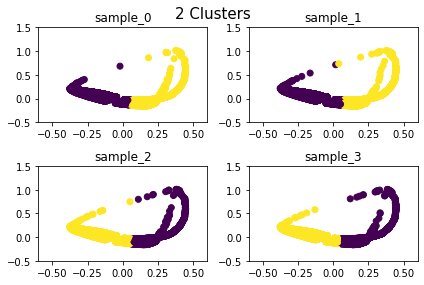

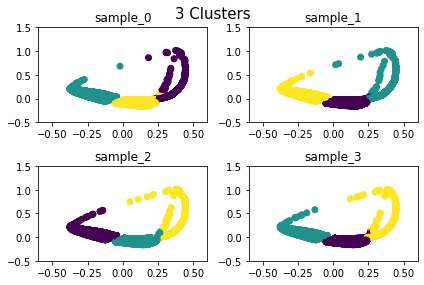

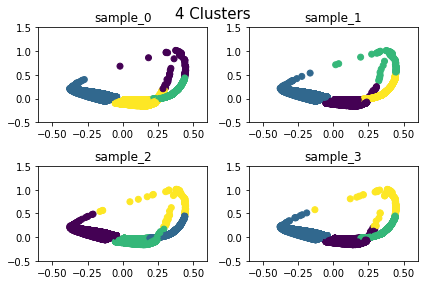

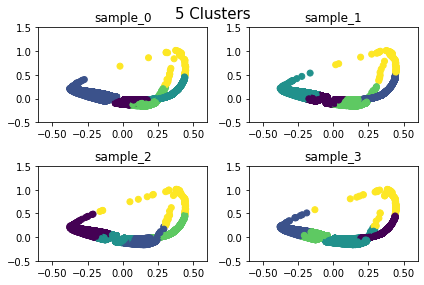

In [22]:
# For each  number of clusters, plot the clusters using the
# pca features for each sample.
for cluster in range(2, 6):
    
    # Make a grid of subplots.
    f, axis_array = plt.subplots(2, 2)
    
    # Make a plot for each sample.
    for i in range(4):
        
        # PCA-created features.
        x_sub = y_pred['feature1_sample_{}'.format(i)]
        y_sub = y_pred['feature2_sample_{}'.format(i)]
        
        # Cluster assignments.
        c = y_pred['cluster{}_sample_{}'.format(cluster, i)]
        
        # Assign the subplot to its place on the grid.
        rows = int(np.floor(i / 2))
        cols = i % 2
        axis_array[rows, cols].scatter(x_sub, y_sub, c=c)
        axis_array[rows, cols].set_title('sample_{}'.format(i))
        axis_array[rows, cols].set_xlim([-.6, .6])
        axis_array[rows, cols].set_ylim([-.5, 1.5])
    
    # Space out the plots so that the headings don't overlap axis values.
    plt.suptitle('{} Clusters'.format(cluster), fontsize=15)
    plt.tight_layout()
    plt.show()
    print('\n')

All the clusters seems to be pretty consistent across all samples; however cluster 4 seems to be more consistent across all samples.

## Spectral Clustering

For the spectral clustering model, we use a range of clusters from 2 to 5, and we calculate the corresponding Silhouette scores for each. 

In [23]:
# Initialize data frames
ypred_sc = pd.DataFrame()
score_sc = pd.DataFrame(columns=['cluster_pred','silhouette_score'])

# Keep track of counts of the models and use data from the different folds
for counter, data in enumerate([
    (X_1, X_pca1),
    (X_2, X_pca2),
    (X_3, X_pca3),
    (X_4, X_pca4)]):
    
    # Put the features into ypred.
    ypred_sc['feature1' + '_sample' + str(counter)] = data[1][:, 0]
    ypred_sc['feature2' + '_sample' + str(counter)] = data[1][:, 1]
    
    # Creating a list of possible number of clusters to test in kmeans.
    for nclust in range(2, 6):
        # Instantiating and fit_predicting model to then add to data frame
        sc = SpectralClustering(n_clusters=nclust)
        
        pred = sc.fit_predict(data[0])
        ypred_sc['clust' + str(nclust) + '_sample' + str(counter)] = pred
        # Calculating silhouette scores for the data and adding that to the shilouette score
        labels = sc.labels_
        sscore_sc = metrics.silhouette_score(data[0], labels, metric='euclidean')
        score_sc = score_sc.append({'cluster_pred':'clust' + str(nclust) + '_sample' + str(counter), 
                              'silhouette_score':sscore_sc}, ignore_index=True)

In [24]:
score_sc.sort_values(by='silhouette_score', ascending=False)

,cluster_pred,silhouette_score
15,clust5_sample3,0.497846
3,clust5_sample0,0.494062
11,clust5_sample2,0.493496
14,clust4_sample3,0.492979
7,clust5_sample1,0.491059
2,clust4_sample0,0.488743
10,clust4_sample2,0.488683
6,clust4_sample1,0.486450
4,clust2_sample1,0.474149
0,clust2_sample0,0.456296


##### A cluster 4 and cluster 5 configuration has the highest silhouette scores.

# Conclusion

The K mean model generated slightly highest Silhouette score with a value at 0.499. This drives us to the conclusion that the are 4 main group of runners in this marathon. 

In [25]:
# Calculate predicted values.
y_pred = KMeans(n_clusters=4, random_state=42).fit_predict(X_norm)

In [26]:
df_y = pd.DataFrame(y_pred)
df_y.columns = ['Cluster']

In [27]:
# Add the outcome back onto X
combined = X.join(df_y, how='inner')
combined.head()

,10k,division,25k,gender,age,official,genderdiv,35k,overall,pace,30k,5k,half,20k,40k,Cluster
0,17.37,8,47.67,1,47,85.25,8,71.40,8,3.27,59.18,8.02,39.72,37.65,80.43,3
1,32.58,1,82.43,0,33,138.95,1,116.37,21,5.30,99.33,16.22,69.47,65.83,132.10,3
2,16.62,1,45.80,1,41,80.60,1,67.42,1,3.08,56.45,7.75,38.03,36.10,76.10,3
3,32.57,3,82.43,0,24,140.58,3,116.37,27,5.37,99.33,16.20,69.47,65.83,132.95,3
4,17.12,2,46.37,1,40,81.23,2,67.83,2,3.10,57.03,8.02,38.60,36.58,76.72,3


In [28]:
# Create age buckets

def age_bucket(age):
    output = ''
    if age <=20:
        output = 'Under 20'
    elif (age > 20 and age <= 30):
        output = 'Between 20 and 30'
    elif (age > 30 and age <= 40):
        output = 'Between 30 and 40'
    elif (age > 40 and age <= 50):
        output = 'Between 40 and 50'
    elif (age > 50 and age <= 60):
        output = 'Between 50 and 60'
    else:
        output = 'Over 60'
    
    return output

In [29]:
combined['Age Range'] = combined['age'].apply(lambda x: age_bucket(x))

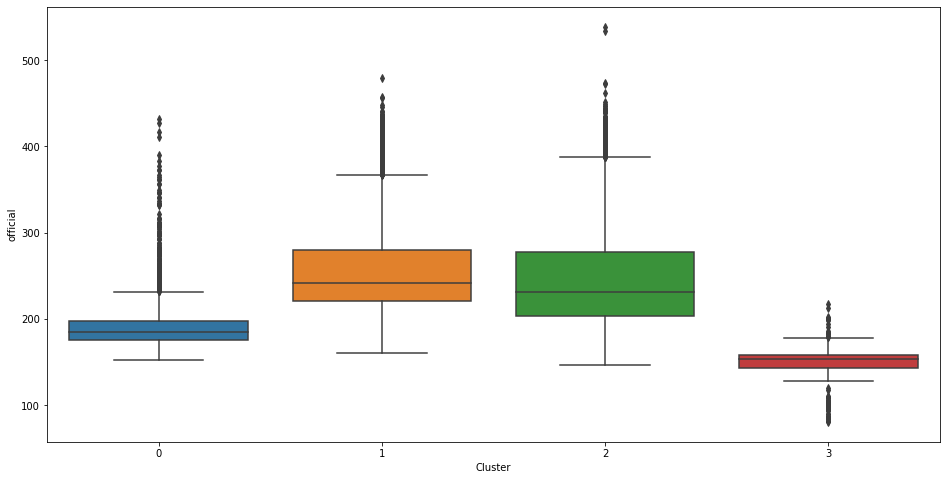

In [30]:
# Official time between the groups
plt.figure(figsize=(16,8))
sns.boxplot(x='Cluster',y='official',data=combined)

From the plot above, the clusters are divided in maximium, intermediate and minumum race time records. Also we notice a number of outliers for each cluster.

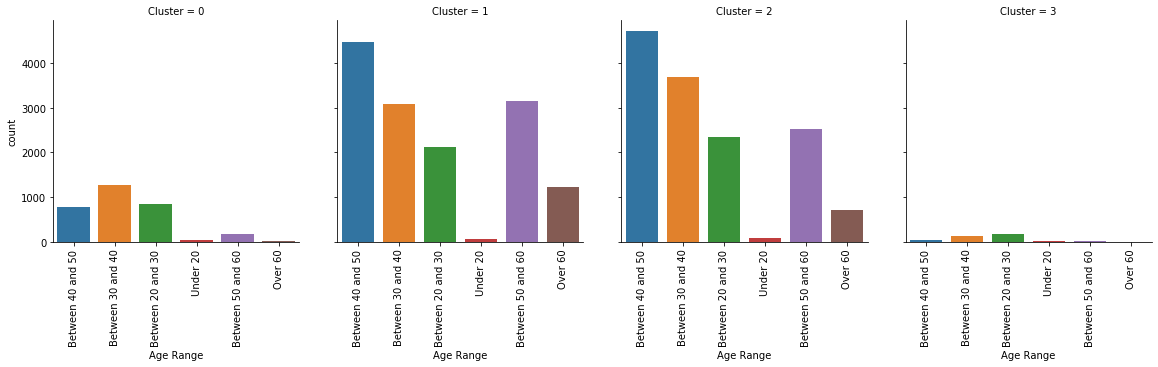

In [32]:
# Look at Gender Breakdown for Count
g = sns.factorplot(x='Age Range', col='Cluster', kind="count", data=combined, size=4)
g.set_xticklabels(rotation=90)


From the plot above we see the best cluster #3 with less time, has a slightly higher number of runners with an age between 20 and 30 over the other runners.

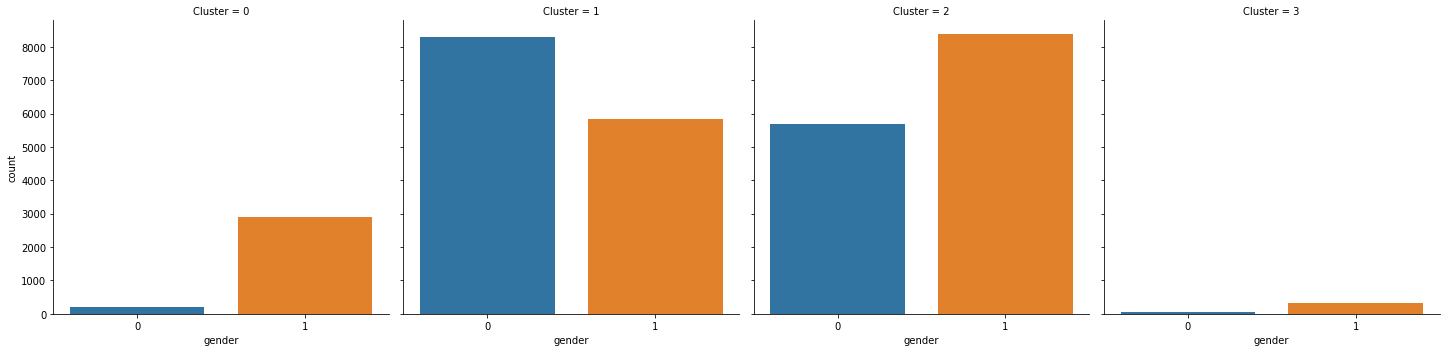

In [33]:
sns.factorplot(x='gender', col='Cluster', kind="count", data=combined, size=5)

Also in cluster 3 there is a predominant number of male runners.

In [34]:
# Separate the clusters
cluster0 = combined[combined['Cluster']==0]
cluster1 = combined[combined['Cluster']==1]
cluster2 = combined[combined['Cluster']==2]
cluster3 = combined[combined['Cluster']==3]

In [35]:
# check Gender Breakdown
cluster0['gender'].value_counts()

1    2892
0     213
Name: gender, dtype: int64

In [36]:
cluster1['gender'].value_counts()

0    8300
1    5823
Name: gender, dtype: int64

In [37]:
cluster2['gender'].value_counts()

1    8371
0    5680
Name: gender, dtype: int64

In [38]:
cluster3['gender'].value_counts()

1    326
0     44
Name: gender, dtype: int64